In [1]:
import numpy as np
from soma import aims
import os
import sparse
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import random
from scipy.ndimage import map_coordinates

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# given two vectors, compute the rotations to map one to the other
def rotation(v1, v2):
    """
    Compute a matrix R that rotates v1 to align with v2.
    v1 and v2 must be length-3 1d numpy arrays.
    """
    # unit vectors
    u = v1 / np.linalg.norm(v1)
    Ru = v2 / np.linalg.norm(v2)
    # dimension of the space and identity
    dim = u.size
    I = np.identity(dim)
    # the cos angle between the vectors
    c = np.dot(u, Ru)
    # a small number
    eps = 1.0e-10
    if np.abs(c - 1.0) < eps:
        # same direction
        return I
    elif np.abs(c + 1.0) < eps:
        # opposite direction
        return -I
    else:
        # the cross product matrix of a vector to rotate around
        K = np.outer(Ru, u) - np.outer(u, Ru)(np.max(aligned_coords,axis=1) - np.min(aligned_coords, axis=1)).astype(int)
        # Rodrigues' formula
        return I + K + (K @ K) / (1 + c)
    
# remove zeros function
def trim_zeros(arr):
    """Returns a trimmed view of an n-D array excluding any outer
    regions which contain only zeros.
    """
    slices = tuple(slice(idx.min(), idx.max() + 1) for idx in np.nonzero(arr))
    return arr[slices], slices

def draw3DRectangle(ax, x1, y1, z1, x2, y2, z2):
    # the Translate the datatwo sets of coordinates form the apposite diagonal points of a cuboid
    ax.plot([x1, x2], [y1, y1], [z1, z1], color='b') # | (up)
    ax.plot([x2, x2], [y1, y2], [z1, z1], color='b') # -->
    ax.plot([x2, x1], [y2, y2], [z1, z1], color='b') # | (down)
    ax.plot([x1, x1], [y2, y1], [z1, z1], color='b') # <--

    ax.plot([x1, x2], [y1, y1], [z2, z2], color='b') # | (up)
    ax.plot([x2, x2], [y1, y2], [z2, z2], color='b') # -->
    ax.plot([x2, x1], [y2, y2], [z2, z2], color='b') # | (down)
    ax.plot([x1, x1], [y2, y1], [z2, z2], color='b') # <--
    
    ax.plot([x1, x1], [y1, y1], [z1, z2], color='b') # | (up)
    ax.plot([x2, x2], [y2, y2], [z1, z2], color='b') # -->
    ax.plot([x1, x1], [y2, y2], [z1, z2], color='b') # | (down)
    ax.plot([x2, x2], [y1, y1], [z1, z2], color='b') # <--

In [3]:
#sulcus = 'CINGULATE.'
#main_sulcus = 'F.C.M.ant.'

sulcus = 'S.T.s.'
#main_sulcus = 'S.C.'
side = 'L'
# before dilation ?
#mask_dir = f'/neurospin/dico/data/deep_folding/current/mask/2mm/L/{main_sulcus}_left.nii.gz'
mask_dir = f'/neurospin/dico/data/deep_folding/current/datasets/UkBioBank/crops/2mm/{sulcus}/mask/{side}mask_cropped.nii.gz'
mask_dir = f'/neurospin/dico/data/deep_folding/current/mask/2mm/{side}/{sulcus}_left.nii.gz'
crops_dir = f'/neurospin/dico/data/deep_folding/current/datasets/hcp/crops/2mm/{sulcus}/mask/{side}crops/'

In [4]:
mask = aims.read(mask_dir)
print(mask.np.shape)
print(mask.header())
s = sparse.COO.from_numpy(mask.np[:,:,:,0])
print(np.min(s.coords, axis=1))
print(np.max(s.coords, axis=1)) # the mask is trimmed

(96, 114, 96, 1)
{ 'volume_dimension' : [ 96, 114, 96, 1 ], 'sizeX' : 96, 'sizeY' : 114, 'sizeZ' : 96, 'sizeT' : 1, 'referential' : '84b1989b-eb68-8665-0049-8feaf3c22679', 'disk_data_type' : 'S16', 'bits_allocated' : 16, 'data_type' : 'S16', 'scale_factor_applied' : 0, 'possible_data_types' : [ 'S16', 'FLOAT', 'DOUBLE' ], 'cal_min' : 0, 'cal_max' : 0, 'freq_dim' : 0, 'phase_dim' : 0, 'slice_dim' : 0, 'slice_code' : 0, 'slice_start' : 0, 'slice_end' : 0, 'slice_duration' : 0, 'storage_to_memory' : [ -1, 0, 0, 95, 0, -1, 0, 113, 0, 0, -1, 95, 0, 0, 0, 1 ], 'voxel_size' : [ 2, 2, 2, 1 ], 'tr' : 1, 'referentials' : [ 'Talairach-MNI template-SPM' ], 'transformations' : [ [ -1, 0, 0, 96, 0, -1, 0, 96, 0, 0, -1, 114, 0, 0, 0, 1 ] ], 'toffset' : 0, 'xyz_units' : 0, 'time_units' : 0, 'descrip' : '', 'aux_file' : '', 'nifti_type' : 1, 'object_type' : 'Volume', 'file_type' : 'NIFTI-1' }
[65 36 34]
[85 86 79]


In [5]:
mask.np.shape

(96, 114, 96, 1)

In [6]:
# take density into account in the point cloud
data = [coords for coords, number in zip(s.coords.T, s.data) for i in range(number)]
data = np.vstack(data).T
# get principal directions of the data
#data = s.coords
cov = np.cov(data)
eval, evec = np.linalg.eig(cov)

[77.15225051 61.28539095 58.11043703]
(3, 42857)
(3, 1000)


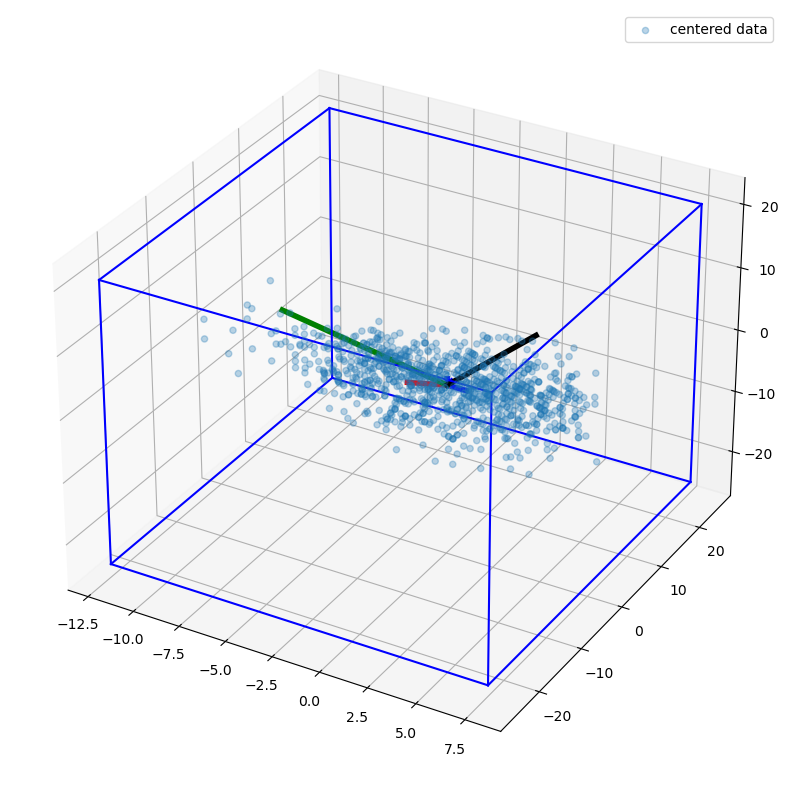

In [7]:
# plot the distribution and new axes
plt.close()
means = np.mean(data, axis=1)
print(means)
centered_data = data - means[:,np.newaxis]
print(centered_data.shape)
list_samples = list(centered_data.T)
samples = np.vstack(random.sample(list_samples, 1000)).T
print(samples.shape)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(data[0,:], data[1,:], data[2,:], label="original data")
#ax.scatter(centered_data[0,:], centered_data[1,:], centered_data[2,:], label="centered data", alpha=1)
ax.scatter(samples[0,:], samples[1,:], samples[2,:], label="centered data", alpha=0.3)
ax.legend()
# cartesian basis
ax.plot([0, 1],  [0, 0], [0, 0], color='b', linewidth=4)
ax.plot([0, 0],  [0, 1], [0, 0], color='b', linewidth=4)
ax.plot([0, 0],  [0, 0], [0, 1], color='b', linewidth=4)
# eigen basis
evec_scaled = 10*evec
ax.plot([0, evec_scaled[0, 0]],  [0, evec_scaled[1, 0]], [0, evec_scaled[2, 0]], color='r', linewidth=4)
ax.plot([0, evec_scaled[0, 1]],  [0, evec_scaled[1, 1]], [0, evec_scaled[2, 1]], color='g', linewidth=4)
ax.plot([0, evec_scaled[0, 2]],  [0, evec_scaled[1, 2]], [0, evec_scaled[2, 2]], color='k', linewidth=4)

xmin, xmax, ymin, ymax, zmin, zmax = np.min(centered_data[0, :]), np.max(centered_data[0, :]), np.min(centered_data[1, :]), np.max(centered_data[1, :]), np.min(centered_data[2, :]), np.max(centered_data[2, :])
draw3DRectangle(ax, xmin, ymin, zmin, xmax, ymax, zmax)
plt.show()

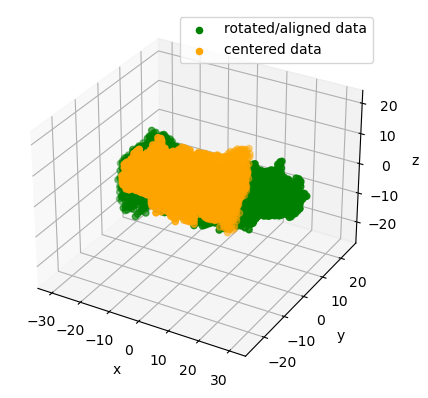

In [8]:
plt.close()
aligned_coords = np.matmul(evec.T, centered_data)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(aligned_coords[0,:], aligned_coords[1,:], aligned_coords[2,:], color='g', label="rotated/aligned data")
ax.scatter(centered_data[0,:], centered_data[1,:], centered_data[2,:], color='orange', label="centered data")
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

In [9]:
## mask without dilation !

size_before = (np.max(centered_data,axis=1) - np.min(centered_data, axis=1)).astype(int) + 1
print(f'bbox size before rotation : {size_before}')
size_after = (np.max(aligned_coords,axis=1) - np.min(aligned_coords, axis=1)).astype(int) + 1
print(f'bbox size after rotation : {size_after}')
print(f'size ratio: {np.prod(size_after) / np.prod(size_before)}')

bbox size before rotation : [21 51 46]
bbox size after rotation : [62 21 24]
size ratio: 0.6342710997442456


# Use aims linear transform

In [10]:
hdr =  aims.StandardReferentials.icbm2009cTemplateHeader()

In [11]:
hdr

{ 'referential' : '84b1989b-eb68-8665-0049-8feaf3c22679', 'referentials' : [ 'Talairach-MNI template-SPM' ], 'transformations' : [ [ -1, 0, 0, 96, 0, -1, 0, 96, 0, 0, -1, 114, 0, 0, 0, 1 ] ], 'volume_dimension' : [ 193, 229, 193, 1 ], 'voxel_size' : [ 1, 1, 1, 1 ] }

In [12]:
hdr['transformations'][0] = aims.AffineTransformation3d(np.eye(4)).toVector()

In [13]:
hdr

{ 'referential' : '84b1989b-eb68-8665-0049-8feaf3c22679', 'referentials' : [ 'Talairach-MNI template-SPM' ], 'transformations' : [ [ 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1 ] ], 'volume_dimension' : [ 193, 229, 193, 1 ], 'voxel_size' : [ 1, 1, 1, 1 ] }

In [23]:
"""
    Resample a volume that contains discret values
"""
import os
import sys
from contextlib import contextmanager
import logging
from time import time
from typing import Union
import tempfile
import subprocess

import numpy as np
from soma import aims
from soma import aimsalgo

def resample(input_image: Union[str, aims.Volume],
             transformation: Union[str, aims.AffineTransformation3d],
             output_vs: tuple = None,
             background: int = 0,
             values: list = None,
             verbose: bool = False,
             do_skel: bool = False,
             immortals: list = None,
             redo_classif: bool = True) -> aims.Volume:
    """
        Transforms and resamples a volume that has discret values

        Parameters
        ----------
        input_image: path to nifti file or aims volume
            Path to the input volume (.nii or .nii.gz file)
        transformation: path to file
            Linear transformation file (.trm file)
        output_vs: tuple
            Output voxel size (default: None, no resampling)
        background: int
            Background value (default: 0)
        values: []
            List of unique values ordered by ascendent priority
            without background. If not given, priority is set by ascending
            values. For Morphologist or deep_folding skeletons (see
            :func:`~deep_folding.brainvisa.utils.skeleton.generate_skeleton_thin_junction`) a good values list is:
            [100, 60, 10, 20, 40, 50, 70, 80, 110, 120, 30, 35].
        do_skel:
            do skeletonization after resampling
        immortals:
            if skeletonization is used, this is the list of voxel values used
            as initial "immortal voxels" in the skeletonization: voxels that
            will not be eroded. Normally border and junctions values, in a
            Morphologist or deep_folding skeleton: [30, 50, 80, 35, 110, 120].
            This is the default.
        redo_classif:
            if True, after re-skeletonization, re-perform voxel topological
            classification. No effect if do_skel is False.

        Return
        ------
        resampled:
            Transformed and resampled volume
    """

    tic = time()

    # Reads input image (either path to file or aims volume)
    if isinstance(input_image, str):
        vol = aims.read(input_image)
    else:
        vol = aims.Volume(input_image)
    vol_dt = vol.np

    # Reads transformation if present (either path to file or aims Volume)
    if transformation:
        if isinstance(transformation, str):
            trm = aims.read(transformation)
        else:
            trm = transformation
    else:
        trm = aims.AffineTransformation3d(np.eye(4))
    inv_trm = trm.inverse()

    ##################################
    # Definition of voxel size and dim
    ##################################

    hdr = aims.StandardReferentials.icbm2009cTemplateHeader()
    if output_vs:
        output_vs = np.array(output_vs)
        # New volume dimensions
        resampling_ratio = np.array(hdr['voxel_size'][:3]) / output_vs
        orig_dim = hdr['volume_dimension'][:3]
        new_dim = list((resampling_ratio * orig_dim).astype(int))
    else:
        output_vs = vol.header()['voxel_size'][:3]
        new_dim = vol.header()['volume_dimension'][:3]

    # new_origin = np.array([77, 61, 58])
    # # Get the current voxel-to-world transformation
    # transformation = aims.AffineTransformation3d(hdr['transformations'][0])

    # # Create a translation matrix
    # translation_matrix = aims.AffineTransformation3d()
    # translation_matrix.setTranslation([-x for x in new_origin])

    # # Combine transformations: Apply translation to move the origin
    # new_transformation = translation_matrix * transformation

    # # Update the image transformation
    # hdr['transformations'][0] = new_transformation.toVector()
    tic = time()

    # Transform the background
    # Using the inverse is more straightforward and supports non-linear
    # transforms
    resampled = aims.Volume(new_dim, dtype=vol_dt.dtype)
    resampled.copyHeaderFrom(hdr)
    resampled.header()['voxel_size'] = output_vs
    resampled.fill(0)

    tic = time()

    unique_val_in_vol = sorted(np.unique(vol_dt[vol_dt != background]))
    if values is None:
        values = unique_val_in_vol
    else:
        values = [v for v in values if v in unique_val_in_vol]

    # if values is not None, values are given in ascending order
    # Note also that background shall not be given in values

    if aims.version() >= (5, 2):

        if immortals is None:
            immortals = [30, 50, 80, 35, 110, 120]
        immortals = [v for v in values if v in immortals]
        values = [v for v in values if v not in immortals] \
            + [v for v in immortals]

        # make sure the background is 0 before transformation into bucket
        # FIXME: what if 0 is actually a non-background label ?
        vol[vol.np == background] = 0

        if do_skel:
            cc_vol = aims.Volume(vol)
            cc_vol[~np.isin(cc_vol.np, immortals)] = 0

            aims.AimsConnectedComponent(
                cc_vol, aims.Connectivity.CONNECTIVITY_26_XYZ, 0,
                False, 0, 0, 0, False)
            bck = aims.BucketMap_VOID()
            bck.setSizeXYZT(*vol.header()['voxel_size'][:3], 1.)
            cvol_bk = aims.RawConverter_rc_ptr_Volume_S16_BucketMap_VOID(True)
            cvol_bk.convert(cc_vol, bck)

            cc_per_v = {}
            for cc, pts in bck.items():
                p = tuple(pts.keys()[0]) + (0, )
                cc_per_v.setdefault(vol[p], []).append(cc)

            repl = {}
            repl_cc = {}
            i = 1
            for v in values:
                if v not in immortals:
                    repl[v] = i
                    i += 1
                else:
                    for vv in cc_per_v[v]:
                        repl_cc[vv] = i
                        i += 1
        else:
            repl = {v: i+1 for i, v in enumerate(values)}
            repl_cc = {}
            cc_per_v = {}
            cc_vol = vol

        replacer = getattr(
            aims, 'Replacer_{}'.format(aims.typeCode(cc_vol.np.dtype)))
        if repl_cc:
            replacer.replace(cc_vol, cc_vol, repl_cc)
        repl.update({v: 0 for v in [x for x in unique_val_in_vol
                                    if x not in values]})
        replacer.replace(vol, cc_vol, repl)

        reorder = True

        toc = time()

        bck = aims.BucketMap_VOID()
        bck.setSizeXYZT(*vol.header()['voxel_size'][:3], 1.)
        cvol_bk = aims.RawConverter_rc_ptr_Volume_S16_BucketMap_VOID(True)
        cvol_bk.convert(cc_vol, bck)
        t_bck = time() - toc
        toc = time()
        # resampleBucket() will process values in ascending order, thus the
        # values order is very important.
        bck2 = aimsalgo.resampleBucket(bck, trm, inv_trm, output_vs)
        t_rs = time() - toc
        toc = time()
        cbk_vol = aims.RawConverter_BucketMap_VOID_rc_ptr_Volume_S16(True)
        cbk_vol.printToVolume(bck2, resampled)
        t_tovol = time() - toc

        if do_skel:
            # skeletonization using Vip command
            # (there are no python bindings for this C library yet)
            # (and VipSkeleton in version 5.1 does not have the -k option)
            immortals_i = range(repl_cc[cc_per_v[immortals[0]][0]],
                                repl_cc[cc_per_v[immortals[-1]][-1]] + 1)
            unique_rsp = np.unique(resampled)
            immortals_i = [v for v in immortals_i if v in unique_rsp]

            # skeleton for border lines (junctions, bottom) will become
            # immortals
            borders = aims.Volume(resampled)
            borders[~np.isin(borders.np, immortals_i)] = 0

            # we must skeletonize the border lines first. For this, we also
            # need to set the lines extremities as immortals. So we must
            # get connected components, set a distance map seed in each cc,
            # make a distance map, get the max for each cc, then do another
            # distance map to get the second extremity of each cc.
            aims.AimsConnectedComponent(
                borders, aims.Connectivity.CONNECTIVITY_26_XYZ, 0, False, 0, 0,
                0, False)
            ccn = np.max(borders.np) + 1
            bck = aims.BucketMap_VOID()
            cvol_bk = aims.RawConverter_rc_ptr_Volume_S16_BucketMap_VOID(True)
            cvol_bk.convert(borders, bck)
            pts = []
            for cc, b in bck.items():
                pts.append(b.keys()[0])
            borders_cc = aims.Volume(borders)
            borders[borders.np != 0] = 1
            borders[tuple(np.array(pts).T)] = np.expand_dims(
                np.arange(2, ccn + 1), 1)
            aimsalgo.AimsDistanceFrontPropagation(borders, 1, 0, 3, 3, 3,
                                                  50, False)
            bbk = [np.where(borders_cc.np == cc) for cc in range(1, ccn)]
            seeds = []
            for cc in range(ccn - 1):
                mi = np.argmax(borders[bbk[cc]])
                seeds.append([bbk[cc][i][mi] for i in range(4)])
            seeds = tuple(np.array(seeds).T)
            borders.fill(0)
            borders[borders_cc.np != 0] = 1
            borders[seeds] = range(2, ccn + 1)
            aimsalgo.AimsDistanceFrontPropagation(borders, 1, 0, 3, 3, 3,
                                                  50, False)
            seeds2 = []
            for cc in range(ccn - 1):
                mi = np.argmax(borders[bbk[cc]])
                seeds2.append([bbk[cc][i][mi] for i in range(4)])
            seeds2 = tuple(np.array(seeds2).T)
            borders.fill(0)
            borders[borders_cc.np != 0] = 1
            borders[seeds] = -103  # immportals value
            borders[seeds2] = -103  # immportals value

            tmp = tempfile.mkstemp(prefix='deep_folding_', suffix='.nii')
            os.close(tmp[0])
            tmp2 = tempfile.mkstemp(prefix='deep_folding_sk_', suffix='.nii')
            os.close(tmp2[0])
            tmps = [tmp[1], tmp2[1]]

            try:
                aims.write(borders, tmp[1])
                # aims.write(borders, '/tmp/borders.nii')  # debug
                cmd = ['VipSkeleton', '-i', tmp[1], '-so', tmp2[1], '-fv', 'n',
                       '-sk', 's', '-p', '0', '-c', 'n', '-k']
                subprocess.check_call(cmd)
                borders = aims.read(tmp2[1])
                # skeleton of resampled with immortals
                sk_in = aims.Volume(resampled)
                # aims.write(sk_in, '/tmp/borders_sk.nii')  # debug
                sk_in[sk_in.np != 0] = 1
                sk_in[borders.np != 0] = -103  # immportals value
                del borders
                aims.write(sk_in, tmp[1])
                cmd = ['VipSkeleton', '-i', tmp[1], '-so', tmp2[1], '-fv', 'n',
                       '-sk', 's', '-p', '0', '-c', 'n', '-k']
                subprocess.check_call(cmd)
                del sk_in
                sk_out = aims.read(tmp2[1])
                # aims.write(sk_out, '/tmp/sk.nii')  # debug
                # replace values in skeletonized image
                resampled[sk_out.np == 0] = 0
                del sk_out
            finally:
                for t in tmps:
                    if os.path.exists(t):
                        os.unlink(t)
                    if os.path.exists(t + '.minf'):
                        os.unlink(t + '.minf')

        if reorder:
            print('restoring values')
            irepl = {v: k for k, v in repl.items()}
            virepl = {v: k for k, v in repl_cc.items()}
            icc = {}
            for k, vv in cc_per_v.items():
                for v in vv:
                    icc[v] = k
            irepl.update({k: icc[v] for k, v in virepl.items()})
            replacer = getattr(
                aims, 'Replacer_{}'.format(aims.typeCode(resampled.np.dtype)))
            replacer.replace(resampled, resampled, irepl)

        if redo_classif and do_skel:
            th = aims.Volume(resampled)
            th[th.np != 0] = 1
            tc = aimsalgo.TopologicalClassifier_Volume_S16()
            topo = tc.doit(th)
            del th
            # replace values changed between aims/vip topological values (see
            # the output of the command "VipTopoClassifMeaning -a") and
            # deep_folding value for external junction, 35, which are now
            # 30 or 80 (bottom or junction).
            resampled[resampled.np != 35] = 0
            resampled2 = aims.Volume(resampled)
            # dilate value 35 1 voxel in each direction
            resampled[:-1, :, :, :] += resampled[1:, :, :, :]
            resampled[1:, :, :, :] += resampled2[:-1, :, :, :]
            resampled[:, :-1, :, :] += resampled2[:, 1:, :, :]
            resampled[:, 1:, :, :] += resampled2[:, :-1, :, :]
            resampled[:, :, :-1, :] += resampled2[:, :, 1:, :]
            resampled[:, :, 1:, :] += resampled2[:, :, :-1, :]
            del resampled2
            # intersect
            topo[np.isin(topo, (30, 80)) & (resampled.np != 0)] = 35
            resampled[:] = topo
            del topo

    else:
        if do_skel:
            print('WARNING: skeletonization is only available with aims/vip '
                  '>= 5.2. You are using {} so this step will not be '
                  'done.'.format(aims.__version__))
        # Create one bucket by value (except background)
        # FIXME: Create several buckets because I didn't understood how to add
        # several bucket to a BucketMap
        for i, v in enumerate(values):
            toc = time()
            bck = aims.BucketMap_VOID()
            bck.setSizeXYZT(*vol.header()['voxel_size'][:3], 1.)
            bk0 = bck[0]
            for p in np.vstack(np.where(vol_dt == v)[:3]).T:
                bk0[list(p)] = v
            t_bck = time() - toc
            toc = time()
            bck2 = aimsalgo.resampleBucket(bck, trm, inv_trm, output_vs)
            t_rs = time() - toc
            toc = time()
            # FIXME: Could not assign the correct value with the converter.
            # TODO: try to reduce time consumation of this part!
            # Using the converter, the new_dim must incremented
            # conv = aims.Converter(intype=bck2, outtype=aims.AimsData(vol))
            # conv.convert(bck2, resampled)
            # Use a for loop instead:
            for p in bck2[0].keys():
                c = p.list()
                if c[0] < new_dim[0] and c[1] < new_dim[1] and c[2] < new_dim[2]:
                    resampled[c[0], c[1], c[2]] = values[i]

            tic = time()

    return resampled


In [15]:
## mark center of mask
print(np.sum(mask.np!=0))
mask.np[mask.np!=0]=1
#mask.np[means[0].astype(int)-2 : means[0].astype(int)+2,
#        means[1].astype(int)-2 : means[1].astype(int)+2,
#        means[2].astype(int)-2 : means[2].astype(int)+2]=35
#mask.np[means[0].astype(int),
#        means[1].astype(int),
#        means[2].astype(int)]=35
#mask.np[mask.np!=35]=0
print(np.unique(mask.np))
print(np.sum(mask.np!=0))

7505
[0 1]
7505


In [16]:
mask.header()

{ 'volume_dimension' : [ 96, 114, 96, 1 ], 'sizeX' : 96, 'sizeY' : 114, 'sizeZ' : 96, 'sizeT' : 1, 'referential' : '84b1989b-eb68-8665-0049-8feaf3c22679', 'disk_data_type' : 'S16', 'bits_allocated' : 16, 'data_type' : 'S16', 'scale_factor_applied' : 0, 'possible_data_types' : [ 'S16', 'FLOAT', 'DOUBLE' ], 'cal_min' : 0, 'cal_max' : 0, 'freq_dim' : 0, 'phase_dim' : 0, 'slice_dim' : 0, 'slice_code' : 0, 'slice_start' : 0, 'slice_end' : 0, 'slice_duration' : 0, 'storage_to_memory' : [ -1, 0, 0, 95, 0, -1, 0, 113, 0, 0, -1, 95, 0, 0, 0, 1 ], 'voxel_size' : [ 2, 2, 2, 1 ], 'tr' : 1, 'referentials' : [ 'Talairach-MNI template-SPM' ], 'transformations' : [ [ -1, 0, 0, 96, 0, -1, 0, 96, 0, 0, -1, 114, 0, 0, 0, 1 ] ], 'toffset' : 0, 'xyz_units' : 0, 'time_units' : 0, 'descrip' : '', 'aux_file' : '', 'nifti_type' : 1, 'object_type' : 'Volume', 'file_type' : 'NIFTI-1' }

In [17]:
rot_mat = evec.T
transform = np.hstack((rot_mat, np.zeros((3,1))))
transform = np.vstack((transform, np.zeros(4)))
#transform[:,3]=np.array([0,0,0, 1])
#shift = np.hstack((means.astype(int),0)) // 2
shift = np.array([58, 77, 61, 0])
#transform[:,3]=np.array([96-50, 96-55, 114-25, 1])
transform[:, 3]=np.array([0, 0, 0, 1])

# small rotation
# transform = np.eye(4)
# angle = 0.5
# transform[1,1]=np.cos(angle)
# transform[2,2]=np.cos(angle)
# transform[1,2]=np.sin(angle)
# transform[2,1]=-np.sin(angle)
# shift = (mask.np.shape[:3] - 2*means).astype(int)
# shift = np.hstack((shift, 1))
# transform[:,3]=shift
# print(transform)

In [18]:
trm = aims.AffineTransformation3d(transform)

In [19]:
mask.header()

{ 'volume_dimension' : [ 96, 114, 96, 1 ], 'sizeX' : 96, 'sizeY' : 114, 'sizeZ' : 96, 'sizeT' : 1, 'referential' : '84b1989b-eb68-8665-0049-8feaf3c22679', 'disk_data_type' : 'S16', 'bits_allocated' : 16, 'data_type' : 'S16', 'scale_factor_applied' : 0, 'possible_data_types' : [ 'S16', 'FLOAT', 'DOUBLE' ], 'cal_min' : 0, 'cal_max' : 0, 'freq_dim' : 0, 'phase_dim' : 0, 'slice_dim' : 0, 'slice_code' : 0, 'slice_start' : 0, 'slice_end' : 0, 'slice_duration' : 0, 'storage_to_memory' : [ -1, 0, 0, 95, 0, -1, 0, 113, 0, 0, -1, 95, 0, 0, 0, 1 ], 'voxel_size' : [ 2, 2, 2, 1 ], 'tr' : 1, 'referentials' : [ 'Talairach-MNI template-SPM' ], 'transformations' : [ [ -1, 0, 0, 96, 0, -1, 0, 96, 0, 0, -1, 114, 0, 0, 0, 1 ] ], 'toffset' : 0, 'xyz_units' : 0, 'time_units' : 0, 'descrip' : '', 'aux_file' : '', 'nifti_type' : 1, 'object_type' : 'Volume', 'file_type' : 'NIFTI-1' }

In [20]:


rotation_matrix = evec.T
rotation_matrix = np.hstack((rotation_matrix, np.zeros((3,1))))
rotation_matrix = np.vstack((rotation_matrix, np.zeros(4)))
rotation_matrix[:,3]=np.array([0,0,0,1])
center = means.astype(int)


# Create the affine transformation from the rotation matrix
rotation_transform = aims.AffineTransformation3d(rotation_matrix)

# Create translations to move the center to the origin, rotate, then move back
translation_to_center = aims.AffineTransformation3d()
translation_to_center.setTranslation(center)

translation_back = aims.AffineTransformation3d()
translation_back.setTranslation(-center)

# Combine transformations: move to center -> rotate -> move back
combined_transform = translation_to_center * rotation_transform * translation_back

# Apply the transformation to the volume
resampler = aims.ResamplerFactory_S16().getResampler(0)
resampler.setDefaultValue(0)
resampler.setRef(mask)

rotated_volume = resampler.doit(combined_transform, mask.shape[0], mask.shape[1], mask.shape[2], (2.,2.,2.))

# Save the rotated volume
aims.write(mask, os.path.join(save_dir, 'mask.nii.gz'))
aims.write(rotated_volume, os.path.join(save_dir, 'rotated_volume.nii.gz'))

NameError: name 'save_dir' is not defined

In [21]:
mask.np[mask.np!=0] = 1

In [28]:
np.unique(mask)

array([0, 1], dtype=int16)

In [24]:
rotated_mask = resample(mask,
                        transformation=trm,
                        output_vs=(2,2,2),
                        values=[1],
                        do_skel=False,
                        immortals=[30, 50, 80, 35, 110, 120],
                        redo_classif=False)

print(np.unique(rotated_mask.np))
print(np.sum(rotated_mask.np!=0))

restoring values
[0]
0


In [ ]:
means

In [ ]:
aims.write(rotated_mask, os.path.join(save_dir, 'translated_mask.nii.gz'))

In [ ]:
rotated_mask.np.shape

In [ ]:
crops_dirs = os.listdir(crops_dir)
crop = aims.read(os.path.join(crops_dir, crops_dirs[0]))
crop.shape

In [ ]:
crop.header()

In [ ]:
rotated_crop.header()

In [ ]:
trm = aims.AffineTransformation3d(transform)

In [ ]:
trm

In [ ]:
#transform = np.eye(4)
#angle = 2
#transform[1,1]=np.cos(angle)
#transform[2,2]=np.cos(angle)
#transform[1,2]=np.sin(angle)
#transform[2,1]=-np.sin(angle)
#transform[:,3]=np.array([25, 53, 48, 1])
#print(transform)

#trm = aims.AffineTransformation3d(transform)

In [ ]:
crop.header()

In [ ]:
print(np.unique(crop, return_counts=True))

In [ ]:
rotated_crop = resample(crop,
                        transformation=trm,
                        output_vs=(2,2,2),
                        values=[100, 60, 10, 20, 40, 50, 70, 80, 110, 120, 30, 35],
                        do_skel=False,
                        immortals=[30, 50, 80, 35, 110, 120],
                        redo_classif=False)

print(rotated_crop.header()['transformations'])
print(np.unique(rotated_crop, return_counts=True))
print(np.sum(rotated_crop.np!=0),
        np.sum(rotated_crop.np==30) / np.sum(rotated_crop.np!=0),
        np.sum(rotated_crop.np==35) / np.sum(rotated_crop.np!=0),
        np.sum(rotated_crop.np==60) / np.sum(rotated_crop.np!=0))

aims.write(rotated_crop, os.path.join(save_dir, f'rotated_true_angle.nii.gz'))

In [ ]:
print(crop.header())

In [ ]:
from soma import aimsalgo

In [ ]:
# from deep_folding.brainvisa.utils.resample import resample
save_dir = '/volatile/jl277509/data/tmp'

angles = [0., 0.1, 0.5, 1, 2, 3]

for angle in angles:


    transform = np.eye(4)
    transform[1,1]=np.cos(angle)
    transform[2,2]=np.cos(angle)
    transform[1,2]=np.sin(angle)
    transform[2,1]=-np.sin(angle)
    transform[:,3]=np.array([96, 96, 114, 1])
    # transform[:,3]=np.array([25, 53, 48, 1])
    # trm = aims.AffineTransformation3d(aims.Quaternion([0, 0, np.sin(angle), np.cos(angle)]))
    # trm.setTranslation((-100,-100,-100))
    print(transform)

    trm = aims.AffineTransformation3d(transform)

    # resp = aims.ResamplerFactory_S16().getResampler(0)
    # resp.setDefaultValue(0)
    # resp.setRef(crop)
    # rotated_crop = resp.doit(trm, 200, 200, 200, (2.,2.,2.))

    rotated_crop = resample(crop,
                            transformation=trm,
                            output_vs=(2,2,2),
                            values=[100, 60, 10, 20, 40, 50, 70, 80, 110, 120, 30, 35],
                            do_skel=True,
                            immortals=[30, 50, 80, 35, 110, 120],
                            redo_classif=False)
    
    print(f'angle : {angle}')
    print(rotated_crop.header()['transformations'])
    print(np.unique(rotated_crop, return_counts=True))
    print(np.sum(rotated_crop.np!=0),
          np.sum(rotated_crop.np==30) / np.sum(rotated_crop.np!=0),
          np.sum(rotated_crop.np==35) / np.sum(rotated_crop.np!=0),
          np.sum(rotated_crop.np==60) / np.sum(rotated_crop.np!=0))
    
    aims.write(rotated_crop, os.path.join(save_dir, f'rotated_{angle}.nii.gz'))

In [ ]:
print(rotated_crop.header())

In [ ]:
#dict(crop.header())['transformations']
print(rotated_crop.header()['transformations'])
np.unique(rotated_crop, return_counts=True)

In [ ]:
np.unique(crop, return_counts=True)

In [ ]:
print(crop.header()['transformations'])

In [ ]:
# import anatomist.api as ana
# from soma.qt_gui.qtThread import QtThreadCall
# from soma.qt_gui.qt_backend import Qt
# a = ana.Anatomist()

In [ ]:
# window = a.createWindow('Sagittal')
# anavol = a.toAObject(rotated_crop)
# window.addObjects(anavol)

# Scipy rotate approach

In [ ]:
r = R.from_matrix(evec.T)
angles = r.as_euler('zyx', degrees=True)
print(angles)
angles = angles[1], angles[0], angles[2]
print(angles)

In [ ]:
dataset = 'UkBioBank'
arrs = np.load(f'/neurospin/dico/data/deep_folding/current/datasets/{dataset}/crops/2mm/{sulcus}/mask/{side}skeleton.npy')
dict_arrs = {'skeleton': arrs}

In [ ]:
print(angles)

dict_rot_arrs = {}

print(f'Original dimension: {arrs.shape}')
axes = [(0, 1), (0, 2), (1, 2)]
for key, arrs in dict_arrs.items():
    print(f'ARRAY TYPE : {key}')
    if key=='distbottom':
        cval=32501
    else:
        cval=0
    arr_list = []
    print(f'Non zero voxels before rotation : {np.sum(arrs!=cval)}')
    for arr in tqdm(arrs):
        arr = arr[:,:,:,0]
        rot_arr = np.copy(arr)
        for ax, angle in zip(axes, angles):
            rot_arr = rotate(rot_arr,
                                angle=angle,
                                axes=ax,
                                order=0,
                                reshape=True,
                                mode='constant',
                                cval=cval)
        arr_list.append(rot_arr)

    rot_arrs = np.stack(arr_list)
    print(f'Non zero voxels after rotation : {np.sum(rot_arrs!=cval)}')
    print(f'Dimension after rotation : {rot_arrs.shape}')
    if key=='distbottom':
        # set 0 to vx to remove (temporarily)
        rot_arrs[rot_arrs==0]=-1
        rot_arrs[rot_arrs>=32500]=0
    rot_arrs_trimmed, slices = trim_zeros(rot_arrs)
    print(slices)
    if key=='distbottom':
        rot_arrs_trimmed[rot_arrs_trimmed==0]=32501
        rot_arrs_trimmed[rot_arrs_trimmed==-1]=0
    print(f'Dimension after trimming : {rot_arrs_trimmed.shape}')
    # volume ration should be < 1 !
    print(f"volume ratio after / before rotation : {np.prod(rot_arrs_trimmed.shape[1:]) / np.prod(arrs.shape[1:])}")
    # are topological values affected ?
    #print(np.unique(arrs, return_counts=True))
    #print(np.unique(rot_arrs_trimmed, return_counts=True))
    rot_arrs_trimmed = np.expand_dims(rot_arrs_trimmed, axis=-1)
    dict_rot_arrs[key]= rot_arrs_trimmed